In [32]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt


In [87]:
play_log_path = '../debug_logs/high_kpd_terrain/terrain1_play_debug_20251106_113625.csv'
sim2sim_log_path = '../debug_logs/high_kpd_terrain/terrain1_sim2sim_debug_20251106_113502.csv'

# play_log_path = '../debug_logs/humanoid_play.csv'
# sim2sim_log_path = '../debug_logs/humanoid_sim2sim.csv'

# Load CSV logs - don't use index_col since the format might vary
play_df = pd.read_csv(play_log_path)
sim2sim_df = pd.read_csv(sim2sim_log_path)

# Set timestep as index after loading
if 'timestep' in play_df.columns:
    play_df.set_index('timestep', inplace=True)
if 'timestep' in sim2sim_df.columns:
    sim2sim_df.set_index('timestep', inplace=True)

In [88]:
# Determine the number of DOFs from the data
num_obs = len([col for col in play_df.columns if col.startswith('obs_')])
num_actions = len([col for col in play_df.columns if col.startswith('action_')])
num_dof = len([col for col in play_df.columns if col.startswith('dof_pos_')])

print(f"Number of observations: {num_obs}")
print(f"Number of actions: {num_actions}")
print(f"Number of DOFs: {num_dof}")
print(f"\nPlay shape: {play_df.shape}")
print(f"Sim2Sim shape: {sim2sim_df.shape}")

Number of observations: 41
Number of actions: 10
Number of DOFs: 10

Play shape: (1000, 81)
Sim2Sim shape: (2000, 91)


In [89]:
play_df.shape, sim2sim_df.shape

((1000, 81), (2000, 91))

In [91]:
play_df.head() # observations (41) + actions (10) + dof pos (10) + dof vel (10) + torque (10)

,obs_0,obs_1,obs_2,obs_3,obs_4,obs_5,obs_6,obs_7,obs_8,obs_9,...,torque_0,torque_1,torque_2,torque_3,torque_4,torque_5,torque_6,torque_7,torque_8,torque_9
timestep,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.282499,3.170245,-0.667094,-0.809521,-4.320467,-1.361517,-3.566933,0.596251,-0.158791,-3.322595
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.308807,3.169214,-0.520421,0.054039,-4.488407,-0.197228,-5.179652,0.910763,0.532732,-2.707819
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.361943,2.474883,-0.287049,-4.609606,-4.699327,2.015908,-6.203151,1.096693,1.383379,-2.077940
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.320080,2.249816,-0.342981,-4.503253,-4.546476,0.885964,-3.390216,0.535192,1.182691,-2.015133
40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.526912,0.634821,0.838255,-5.995678,-5.400072,2.218785,-6.261945,0.826356,0.332722,-1.929291


In [93]:
# find the first none-zero time step of obs_0 (first observation column)
play_start_timestep_idx = play_df['obs_0'].to_numpy().nonzero()[0][0]
play_start_timestep_idx

13

In [94]:
sim2sim_df.head() # observations (41) + actions (10) + q or dof pos (10) +  dq or dof vel (10) + target_q or target dof pos (10)+ dof tau (10) = 91

,obs_0,obs_1,obs_2,obs_3,obs_4,obs_5,obs_6,obs_7,obs_8,obs_9,...,tau_0,tau_1,tau_2,tau_3,tau_4,tau_5,tau_6,tau_7,tau_8,tau_9
timestep,,,,,,,,,,,,,,,,,,,,,
0,0.000000,1.000000,1.2,0.0,0.0,2.529515e-20,6.896373e-21,1.571157e-20,-4.161749e-20,5.399901e-20,...,3.058642,4.646713,-0.164035,-8.530238,-0.615312,-1.364039,-6.185494,3.848669,-3.109918,1.137419
10,0.098017,0.995185,1.2,0.0,0.0,2.365261e-02,7.989032e-04,8.696615e-04,-6.311477e-02,8.311523e-03,...,3.120099,2.328012,-1.314203,-1.005796,11.345780,2.106969,-9.416434,0.560778,0.413943,16.690134
20,0.195090,0.980785,1.2,0.0,0.0,4.861201e-02,1.429004e-03,-1.018953e-02,-1.140315e-01,2.603641e-02,...,-0.628220,-0.345515,0.952315,-2.950939,16.769730,1.171688,-8.965736,-1.613865,-0.856458,19.782757
30,0.290285,0.956940,1.2,0.0,0.0,5.920769e-02,1.641021e-03,-1.508598e-02,-1.027774e-01,-1.112755e-02,...,-0.799885,-1.938402,1.183018,-6.192752,19.293737,1.112826,-8.564233,-0.415615,-1.936738,21.015195
40,0.382683,0.923880,1.2,0.0,0.0,6.581093e-02,8.563120e-04,-1.350901e-02,-9.692199e-02,1.265827e-02,...,3.435191,-4.061878,0.124963,-7.192085,-4.130918,3.615339,-11.755363,0.663868,-4.331773,20.831923


In [95]:
"""
obs[0, 0] = math.sin(2 * math.pi * count_lowlevel * cfg.sim_config.dt  / 0.64)
            obs[0, 1] = math.cos(2 * math.pi * count_lowlevel * cfg.sim_config.dt  / 0.64)
            obs[0, 2] = cmd.vx * cfg.normalization.obs_scales.lin_vel
            obs[0, 3] = cmd.vy * cfg.normalization.obs_scales.lin_vel
            obs[0, 4] = cmd.dyaw * cfg.normalization.obs_scales.ang_vel
            obs[0, 5:15] = q * cfg.normalization.obs_scales.dof_pos
            obs[0, 15:25] = dq * cfg.normalization.obs_scales.dof_vel
            obs[0, 25:35] = action
            obs[0, 35:38] = omega
            obs[0, 38:41] = eu_ang
"""
Observations_columns = ['sin_phase', 'cos_phase', 'cmd_vx', 'cmd_vy', 'cmd_dyaw', *[f'dof_pos_{i}' for i in range(num_dof)], *[f'dof_vel_{i}' for i in range(10)], *[f'action_{i}' for i in range(num_dof)], 'omega_x', 'omega_y', 'omega_z', 'euler_x', 'euler_y', 'euler_z']

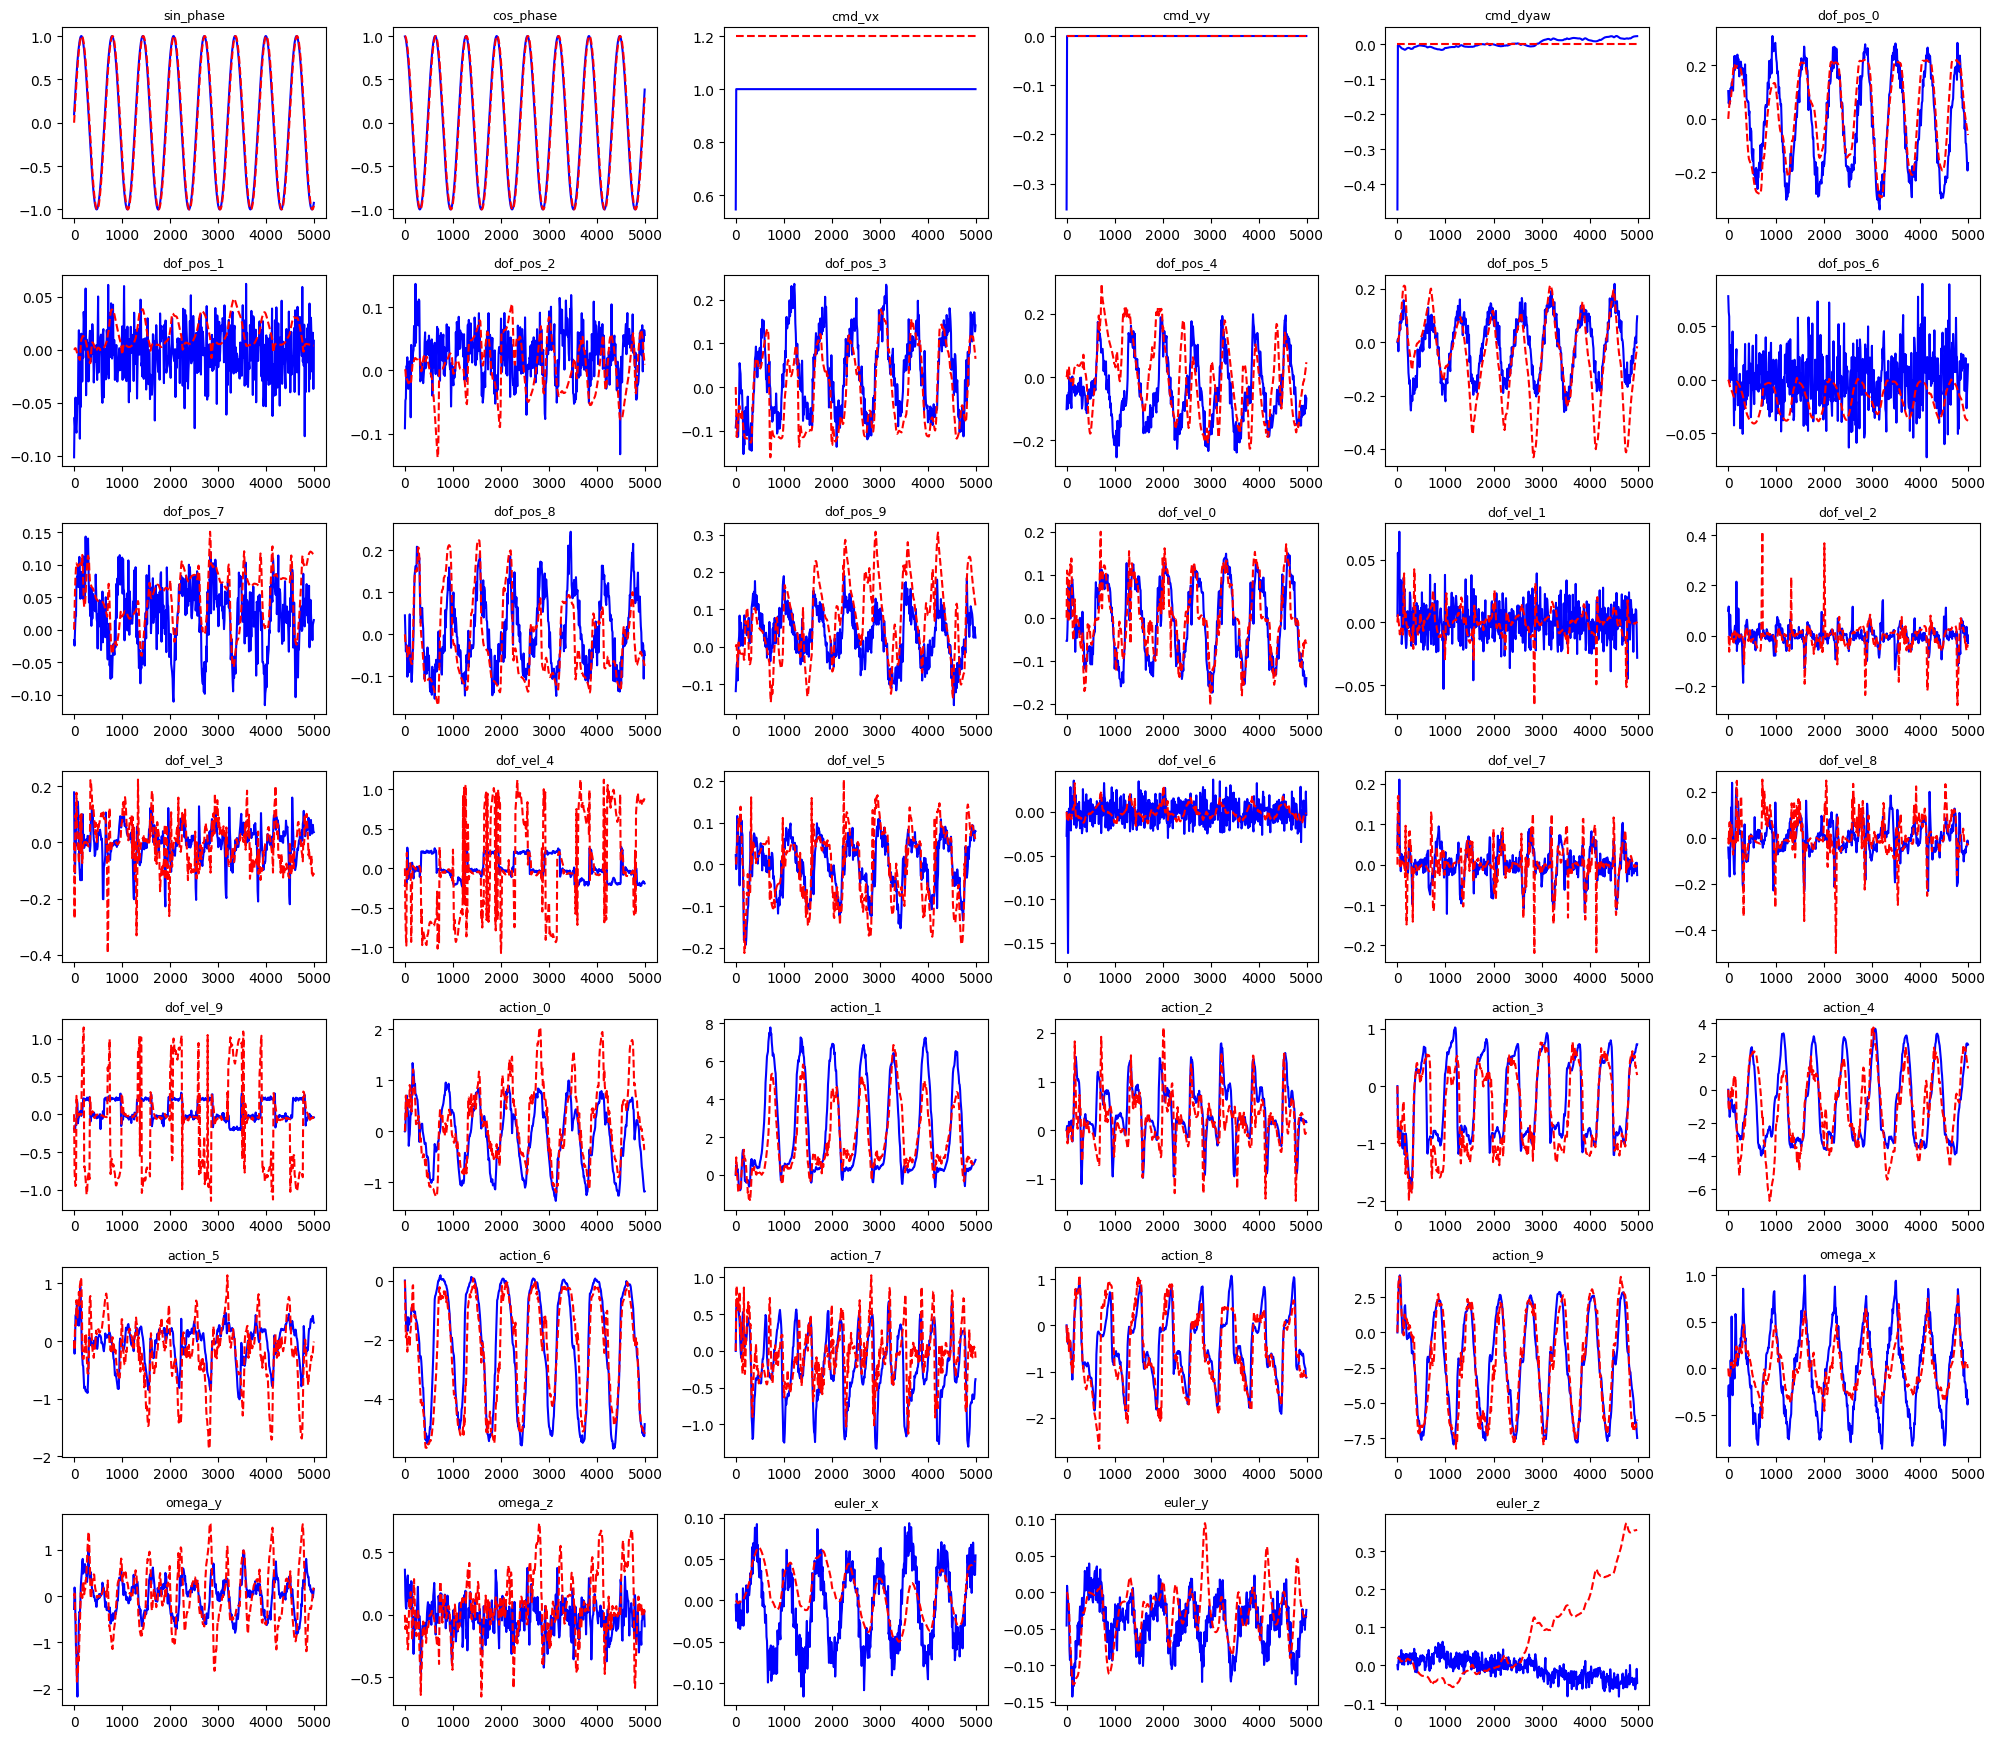

In [96]:
# visualize first 500 timesteps
visual_steps = 500
visual_steps_play = visual_steps + play_start_timestep_idx # align with sim2sim

obs_play = play_df.iloc[play_start_timestep_idx:visual_steps_play, :num_obs].to_numpy()
obs_sim2sim = sim2sim_df.iloc[:visual_steps, :num_obs].to_numpy()

# Plot comparison of observations
time_steps = np.arange(visual_steps) * 10  # timesteps (decimation = 10)

# Determine grid size based on number of observations
n_obs_to_plot = min(obs_play.shape[1], 48)  # Limit to 48 (8x6 grid)
n_rows = int(np.ceil(n_obs_to_plot / 6))
n_cols = 6

plt.figure(figsize=(20, n_rows * 2.5))
for i in range(n_obs_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(time_steps, obs_play[:, i], label='Isaac Gym', color='blue')
    plt.plot(time_steps, obs_sim2sim[:, i], label='Mujoco', color='red', linestyle='--')
    if i < len(Observations_columns):
        plt.title(Observations_columns[i], fontsize=9)
    else:
        plt.title(f'obs_{i}', fontsize=9)
    
plt.tight_layout()
plt.show()

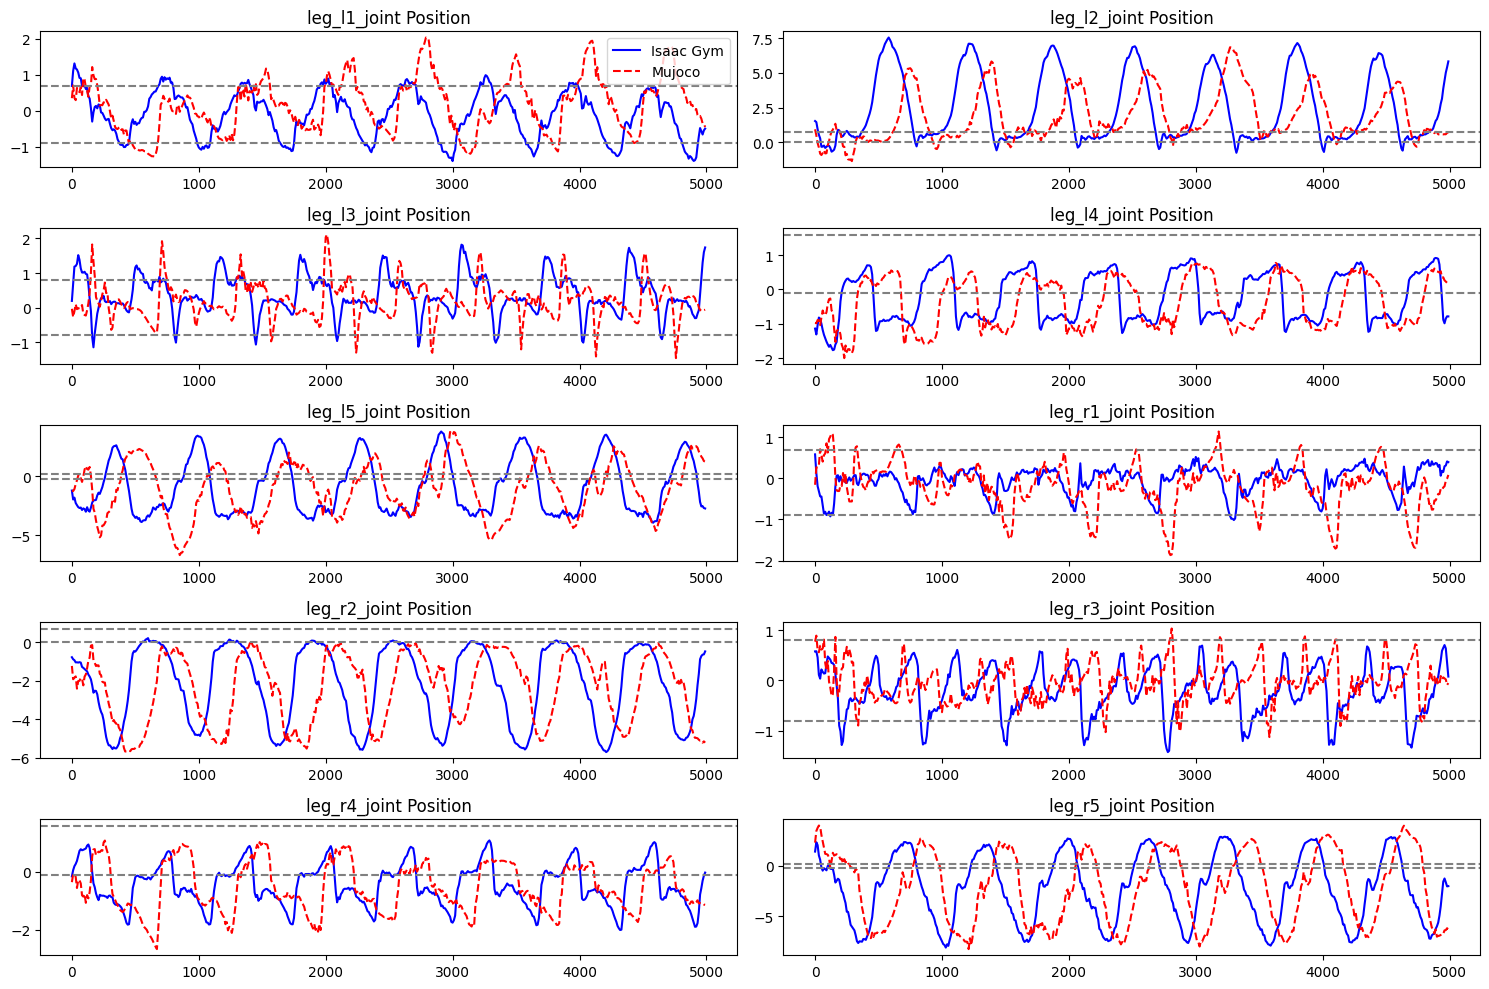

In [97]:
# dof pos comparison - extract only leg joints (first 10 DOFs)
obs_end = num_obs
dof_pos_start = obs_end
dof_pos_end = dof_pos_start + min(10, num_dof)  # Use first 10 DOFs (legs only)

dof_pos_play = play_df.iloc[play_start_timestep_idx:visual_steps_play, dof_pos_start:dof_pos_end].to_numpy()
dof_pos_sim2sim = sim2sim_df.iloc[:visual_steps, num_obs:num_obs+10].to_numpy()  # q in sim2sim

joints_limits = {
    1: (-0.9, 0.7),
    2: (0, 0.7),
    3: (-0.8, 0.8),
    4: (-0.1, 1.6),
    5: (-0.2, 0.2)
}
joints_names = [f'leg_l{i}_joint' for i in range(1,6)] + [f'leg_r{i}_joint' for i in range(1,6)]

plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.plot(time_steps, dof_pos_play[:, i], label='Isaac Gym', color='blue')
    plt.plot(time_steps, dof_pos_sim2sim[:, i], label='Mujoco', color='red', linestyle='--')
    plt.title(joints_names[i] + ' Position')
    if i == 0:
        plt.legend()
    lower_limit, upper_limit = joints_limits[(i % 5) + 1]
    plt.axhline(y=lower_limit, color='gray', linestyle='--')
    plt.axhline(y=upper_limit, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

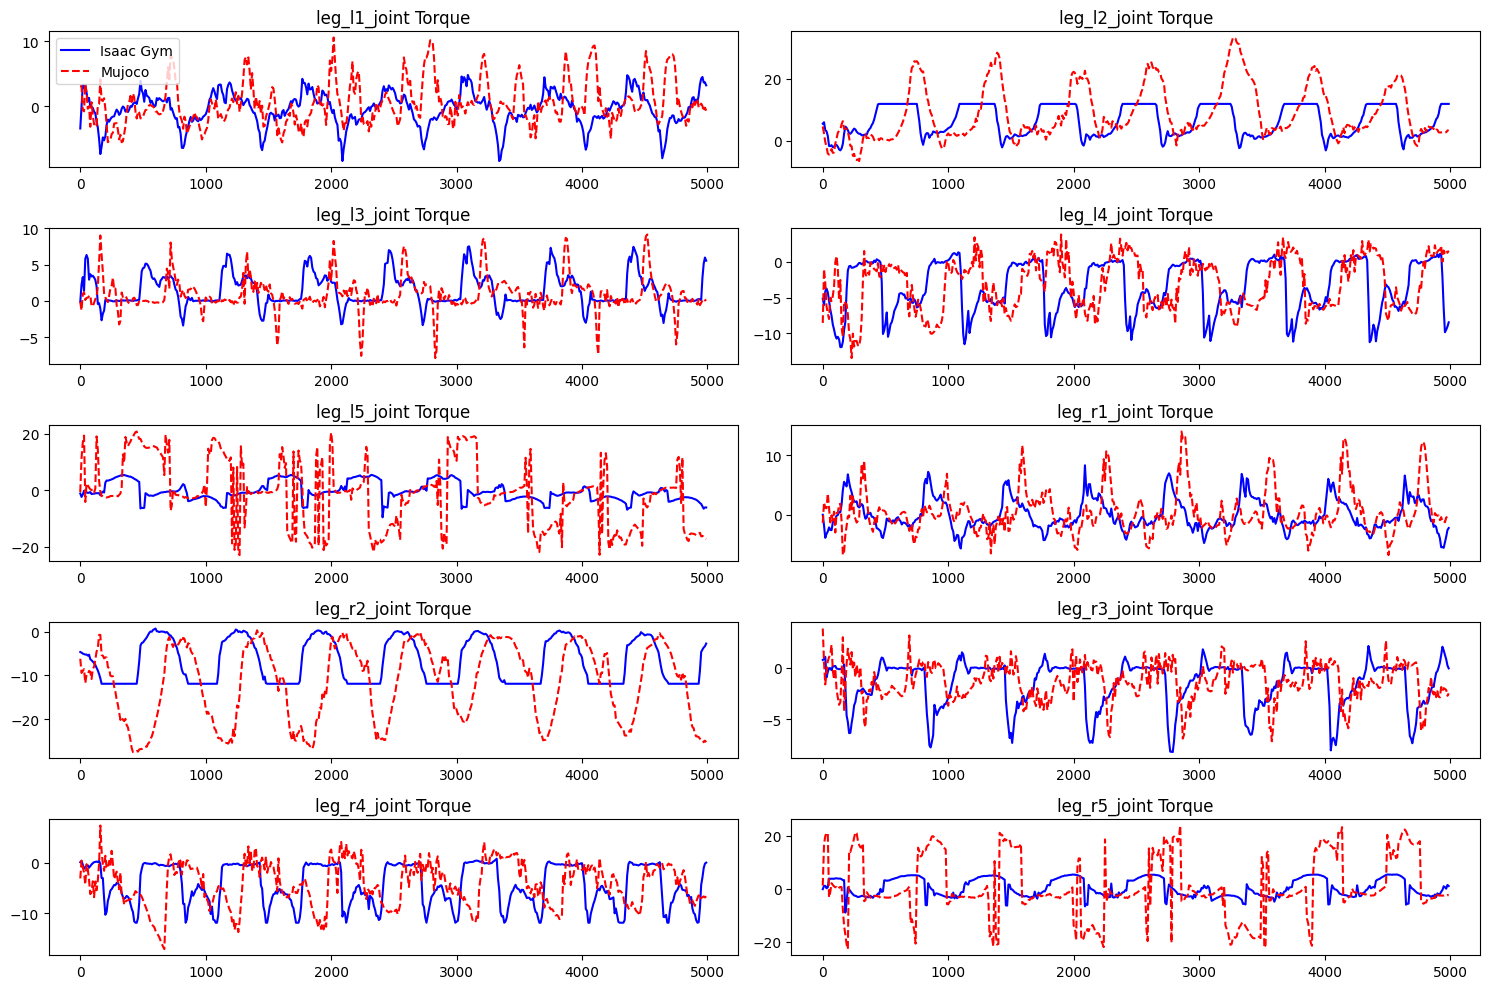

In [99]:
# plot torque comparison for legs (first 10 DOFs)
# Play: obs (41) + actions (12) + dof_pos (12) + dof_vel (12) + torque (12)
torque_start_play = num_obs + num_actions + num_dof + num_dof
dof_torque_play = play_df.iloc[play_start_timestep_idx:visual_steps_play, torque_start_play:torque_start_play+10].to_numpy()

# Sim2sim: obs (41) + actions (12) + q (12) + dq (12) + target_q (12) + tau (12) 
torque_start_sim2sim = num_obs + num_actions + num_actions + num_actions + num_actions
dof_torque_sim2sim = sim2sim_df.iloc[:visual_steps, torque_start_sim2sim:torque_start_sim2sim+num_dof].to_numpy()

plt.figure(figsize=(15, 10))
for i in range(num_dof):
    plt.subplot(5, 2, i + 1)
    plt.plot(time_steps, dof_torque_play[:, i], label='Isaac Gym', color='blue')
    plt.plot(time_steps, dof_torque_sim2sim[:, i], label='Mujoco', color='red', linestyle='--')
    plt.title(joints_names[i] + ' Torque')
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

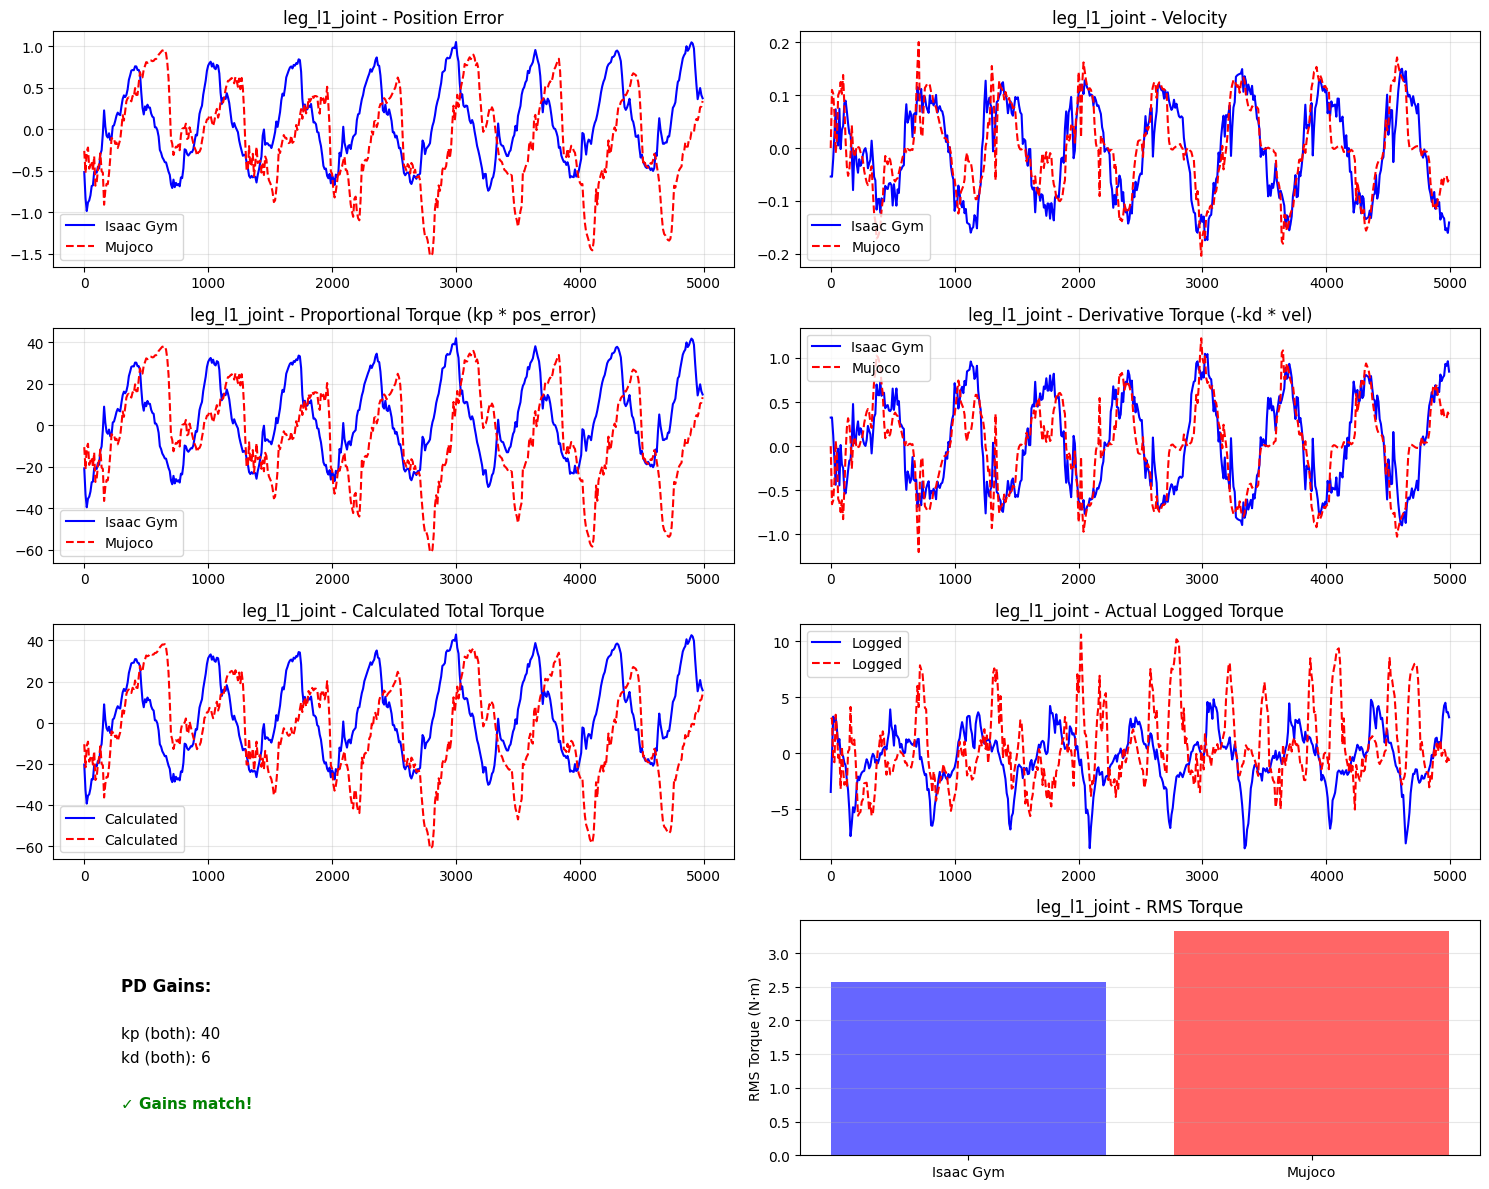


leg_l1_joint Analysis:
RMS Torque - Isaac Gym: 2.56 N⋅m
RMS Torque - Mujoco: 3.32 N⋅m
Torque Ratio (Mujoco/Isaac): 1.30x
PD Gains: kp=40, kd=6


In [100]:
# Biped Torque Analysis - Decompose torque components
joint_idx = 0  # leg_l1_joint
joint_name = joints_names[joint_idx]

# Get action columns for position error calculation
action_start = num_obs
pos_error_play = (play_df.iloc[play_start_timestep_idx:visual_steps_play, action_start + joint_idx].to_numpy() * 0.25 + 
                  0.0 - dof_pos_play[:, joint_idx])
pos_error_sim2sim = (sim2sim_df.iloc[:visual_steps, action_start + joint_idx].to_numpy() * 0.25 + 
                     0.0 - dof_pos_sim2sim[:, joint_idx])

# Get velocities - they're in observations
vel_obs_start = 5 + num_dof  # After sin, cos, cmd_vx, cmd_vy, cmd_dyaw, and dof_pos
vel_play = play_df.iloc[play_start_timestep_idx:visual_steps_play, vel_obs_start + joint_idx].to_numpy()
vel_sim2sim = sim2sim_df.iloc[:visual_steps, vel_obs_start + joint_idx].to_numpy()

# PD gains for biped legs
kp = 40
kd = 6

# Calculate torque components
torque_p_play = kp * pos_error_play
torque_d_play = -kd * vel_play
torque_total_play = torque_p_play + torque_d_play

torque_p_sim2sim = kp * pos_error_sim2sim  
torque_d_sim2sim = -kd * vel_sim2sim
torque_total_sim2sim = torque_p_sim2sim + torque_d_sim2sim

# Plot decomposition
fig, axes = plt.subplots(4, 2, figsize=(15, 12))

axes[0, 0].plot(time_steps, pos_error_play, label='Isaac Gym', color='blue')
axes[0, 0].plot(time_steps, pos_error_sim2sim, label='Mujoco', color='red', linestyle='--')
axes[0, 0].set_title(f'{joint_name} - Position Error')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(time_steps, vel_play, label='Isaac Gym', color='blue')
axes[0, 1].plot(time_steps, vel_sim2sim, label='Mujoco', color='red', linestyle='--')
axes[0, 1].set_title(f'{joint_name} - Velocity')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(time_steps, torque_p_play, label='Isaac Gym', color='blue')
axes[1, 0].plot(time_steps, torque_p_sim2sim, label='Mujoco', color='red', linestyle='--')
axes[1, 0].set_title(f'{joint_name} - Proportional Torque (kp * pos_error)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(time_steps, torque_d_play, label=f'Isaac Gym', color='blue')
axes[1, 1].plot(time_steps, torque_d_sim2sim, label=f'Mujoco', color='red', linestyle='--')
axes[1, 1].set_title(f'{joint_name} - Derivative Torque (-kd * vel)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

axes[2, 0].plot(time_steps, torque_total_play, label='Calculated', color='blue')
axes[2, 0].plot(time_steps, torque_total_sim2sim, label='Calculated', color='red', linestyle='--')
axes[2, 0].set_title(f'{joint_name} - Calculated Total Torque')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].plot(time_steps, dof_torque_play[:, joint_idx], label='Logged', color='blue')
axes[2, 1].plot(time_steps, dof_torque_sim2sim[:, joint_idx], label='Logged', color='red', linestyle='--')
axes[2, 1].set_title(f'{joint_name} - Actual Logged Torque')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

axes[3, 0].text(0.1, 0.7, f'PD Gains:', fontsize=12, weight='bold')
axes[3, 0].text(0.1, 0.5, f'kp (both): {kp}', fontsize=11)
axes[3, 0].text(0.1, 0.4, f'kd (both): {kd}', fontsize=11)
axes[3, 0].text(0.1, 0.2, f'✓ Gains match!', fontsize=11, color='green', weight='bold')
axes[3, 0].axis('off')

rms_play = np.sqrt(np.mean(dof_torque_play[:, joint_idx]**2))
rms_sim2sim = np.sqrt(np.mean(dof_torque_sim2sim[:, joint_idx]**2))
axes[3, 1].bar(['Isaac Gym', 'Mujoco'], [rms_play, rms_sim2sim], color=['blue', 'red'], alpha=0.6)
axes[3, 1].set_title(f'{joint_name} - RMS Torque')
axes[3, 1].set_ylabel('RMS Torque (N⋅m)')
axes[3, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n{joint_name} Analysis:")
print(f"RMS Torque - Isaac Gym: {rms_play:.2f} N⋅m")
print(f"RMS Torque - Mujoco: {rms_sim2sim:.2f} N⋅m")
print(f"Torque Ratio (Mujoco/Isaac): {rms_sim2sim/rms_play:.2f}x")
print(f"PD Gains: kp={kp}, kd={kd}")